In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.utils.data as td
import torchvision.datasets as datasets
from torchvision import models
from sklearn.model_selection import KFold
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import time
import os, random
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
import torch.optim as optim
from torch.optim import Adam
import os, cv2, random, json, itertools
from tqdm import tqdm
import pandas as pd

In [22]:
root_dir = "/content/drive/MyDrive/archive/images"

In [23]:
def count_target_classes(root_dir):
    '''return count of number of images per class'''
    target_classes = {}
    for folder in sorted(os.listdir(root_dir)):
        data_path_for_image_folder = root_dir+ '/'+str(folder) + '/'
        target_classes[str(folder)] = len([image_filename for image_filename in sorted(os.listdir(data_path_for_image_folder))])
    return target_classes

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
dict_class_count = count_target_classes(root_dir)

In [26]:
print("Total number of images for the datasets are :",sum(dict_class_count.values()))

Total number of images for the datasets are : 10500


In [27]:
def plot_hist(dict_target_count):
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(30,15))
    plt.bar(dict_target_count.keys(), dict_target_count.values(), 
            color= ['aqua', 'gold', 'green', 'blue'], edgecolor='k')
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Number of images per class")
    plt.show()
    plt.close()

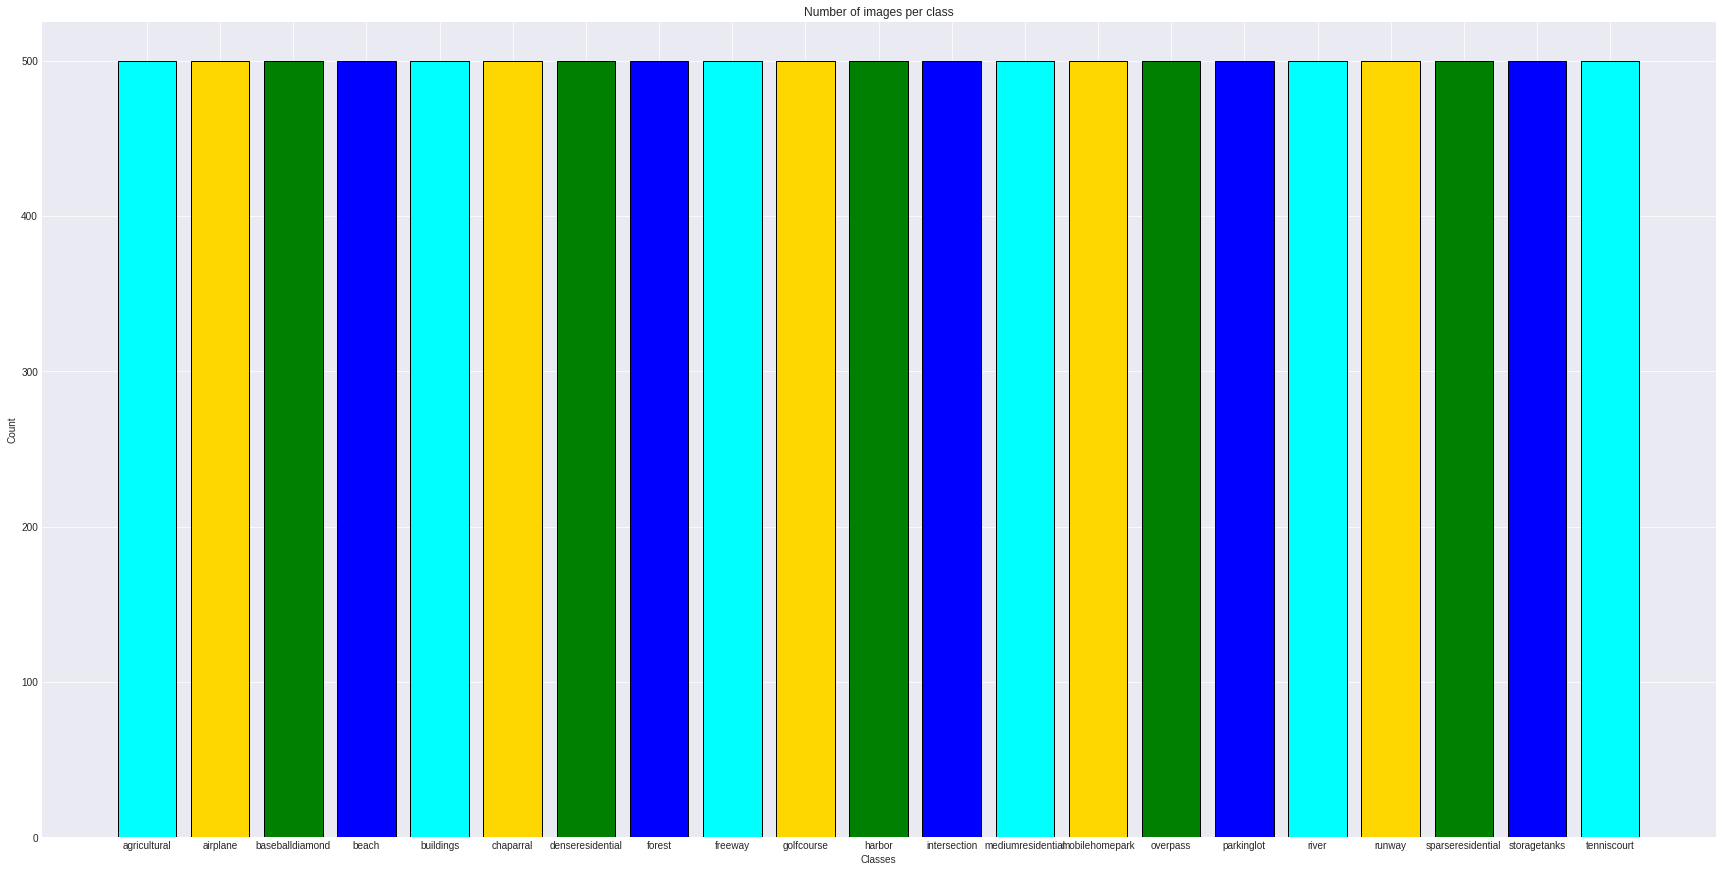

In [28]:
plot_hist(dict_class_count)

In [ ]:
def print_images(root_dir):
    '''return count of number of images per class'''
    plt.style.use('seaborn-white')
    images_plt=[]
    classes=[]
    f, axarr = plt.subplots(1,4, figsize=(15,15)) 
    for folder in sorted(os.listdir(root_dir)):
      image_folder = root_dir+ '/'+str(folder) + '/'
      classes.append(str(folder))
      images_plt.append(image.imread(random.choice([image_folder+image_filename for image_filename in sorted(os.listdir(image_folder))])))

    axarr[0].imshow(images_plt[0])
    axarr[0].set_title(classes[0])
    axarr[1].imshow(images_plt[1])
    axarr[1].set_title(classes[1])
    axarr[2].imshow(images_plt[2])
    axarr[2].set_title(classes[2])
    axarr[3].imshow(images_plt[3])
    axarr[3].set_title(classes[3])
    plt.show

In [ ]:
print_images(root_dir)

In [33]:
def load_dataset(path, test_split, batch_size, input_size):

    transform_dict = {'src':  transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])}

    data = datasets.ImageFolder(root=path, transform=transform_dict["src"])

    test_size = int(len(data) * test_split)
    train_size = len(data)- test_size

    train_dataset, test_dataset = td.random_split(data, [train_size, test_size])

    return train_dataset,test_dataset

In [36]:
dataset, test_dataset = load_dataset(root_dir, test_split=0.2, batch_size=32, input_size=[256,256])

In [37]:
train_loader = td.DataLoader(dataset, batch_size = 32, shuffle=True, num_workers = 0)

In [38]:
for image, label in train_loader:
    print(image.shape)
    print(label)
    break

torch.Size([32, 3, 32, 32])
tensor([ 1, 16, 20,  9, 11, 10, 11, 12, 10, 14, 18,  8,  8,  6, 15,  9,  9,  9,
        11,  7, 14,  0, 14, 16,  7,  6, 12, 14, 12, 18,  7, 16])


In [39]:
def train(num_epochs, model, train_loader, criterion, optimizer):
    
    ######## Write your code here ##############
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: {}".format(device))
    model.to(device)
    total_steps = len(train_loader)
    lossLst_1 = []
    accLst_1 = []
    ############ Define the training loop here ###########
    for epoch in range(num_epochs):
        lossLst_2 = []
        accLst_2 = []
        for i, data in enumerate(train_loader):
            images, labels = data[0].to(device), data[1].to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            lossLst_2.append(loss)
            # Backprop and optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Train accuracy
            total = labels.size(0)
            _,predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            accLst_2.append((correct / total) * 100)
        meanAcc = sum(accLst_2) / len(accLst_2)
        meanLoss = sum(lossLst_2) / len(lossLst_2)
        lossLst_1.append(meanAcc)
        accLst_1.append(meanLoss)
        print('Epoch [{}/{}], Accuracy: {:.2f}%, Mean Loss: {:.2f}'.format(epoch + 1, num_epochs, meanAcc, meanLoss))
    return accLst_1, lossLst_1, model

In [40]:
model = models.vgg16()  # By default, no pre-trained weights are used.
input_lastLayer = model.classifier[6].in_features
model.classifier[6] = nn.Linear(input_lastLayer,21)
# define the loss function
criterion = nn.CrossEntropyLoss()
#Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [41]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
num_epochs = 10
accLst_1, lossLst_1, model = train(num_epochs, model, train_loader, criterion, optimizer)